### Notebook to Demonstrate Gradient Decent Over Intrinsic ###

In [1]:
# Basic Imports
from intrinsic.module import PlasticEdges
from intrinsic.model import Intrinsic
import numpy as np
import torch
from matplotlib import pyplot as plt

We'll initialize a fully connected Intrinsic network with 3 state nodes, each with 3 channels and spatial dimmesnions with size 5x5. 

In [2]:
rnet = Intrinsic(num_nodes=3, node_shape=(1, 3, 5, 5), kernel_size=3, edge_module=PlasticEdges, track_activation_history=True, mask=None, inject_noise=True, optimize_weights=False)

Using kernel 3  and pad 1


First run 1000 iterations of the randomly initialized network with no input to get a sense of what it's internal dynamics are like. 

In [3]:
for i in range(1000):
    rnet()

Plot the series of states for some unit somewhere in the middle of the run (ideally after the dynamics have largely converged). Here we look at time step 200 - 600 of a unit at spatial location (1, 1) in channel 1 of node 2

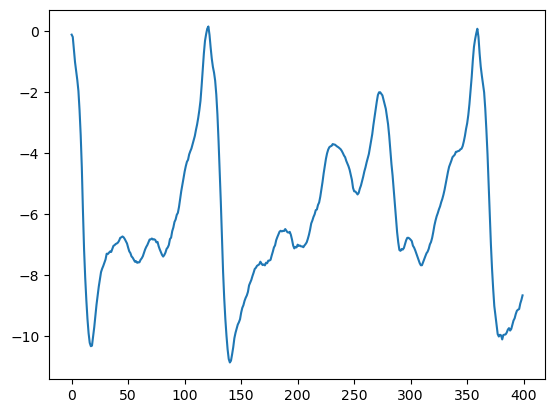

In [4]:
history = rnet.past_states
history = np.array([s.detach().squeeze().numpy() for s in history])
plt.plot(history[200:600, 2, 1, 1, 1])

Note that there are some semi-repetitive oscillatory dynamics that arise from the structure and local update functions on the random graph. 

 Now attempt to use gradient decent to alter the dynamics at this unit to match a given temporal pattern (a cosine function, below)

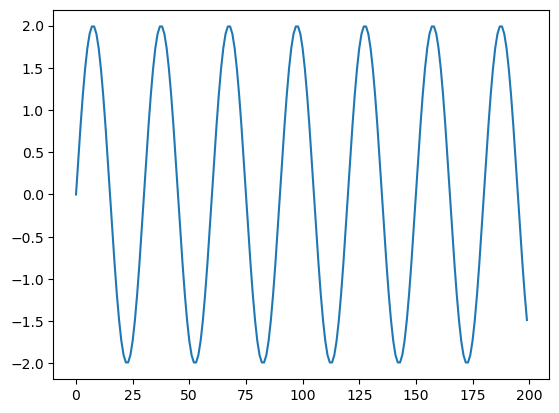

In [5]:
x = torch.arange(0, 200)
target_pattern = 2 * torch.sin((x * 4 * torch.pi) / 60)
plt.plot(target_pattern)

In [6]:
loss_history = []

In the below training loop, take the time course of unit of interest (2, 1, 1, 1) at each generation and compute the mean square error (mse) relative to the target cosine time series above. This mse is minimized via gradient decent over the initial weight, channel map, and plasticity parameters of the model ~200 parameters.

In [11]:
# initialize a sgd optimizer over global parameters
optim = torch.optim.Adam(params=rnet.parameters(), eps=1e-6, lr=.001)
# we will run 1250 generations with gradient update after each gen
for gen in range(2000):
    rnet.past_states = []
    rnet = rnet.detach(reset_intrinsic=True)
    optim.zero_grad()
    # will model 200 time steps per generation
    for i in range(200):
        rnet()
    history = torch.stack(rnet.past_states)
    node_history = history[:, 2, 1, 1, 1].squeeze()
    # compute the mean square error between target time series and observed time series at unit of interest
    loss = torch.sqrt(torch.sum((target_pattern - node_history) ** 2))
    loss_history.append(loss.detach().cpu().item())
    print("gen", gen, "loss", loss)
    # preform gradient update.
    loss.backward()
    optim.step()

gen 0 loss tensor(23.5452, grad_fn=<SqrtBackward0>)
gen 1 loss tensor(23.5234, grad_fn=<SqrtBackward0>)
gen 2 loss tensor(31.0089, grad_fn=<SqrtBackward0>)
gen 3 loss tensor(22.8740, grad_fn=<SqrtBackward0>)
gen 4 loss tensor(22.7109, grad_fn=<SqrtBackward0>)
gen 5 loss tensor(22.4217, grad_fn=<SqrtBackward0>)
gen 6 loss tensor(22.5456, grad_fn=<SqrtBackward0>)
gen 7 loss tensor(22.6143, grad_fn=<SqrtBackward0>)
gen 8 loss tensor(22.7141, grad_fn=<SqrtBackward0>)
gen 9 loss tensor(22.8068, grad_fn=<SqrtBackward0>)
gen 10 loss tensor(22.9941, grad_fn=<SqrtBackward0>)
gen 11 loss tensor(22.2610, grad_fn=<SqrtBackward0>)
gen 12 loss tensor(22.4375, grad_fn=<SqrtBackward0>)
gen 13 loss tensor(22.5299, grad_fn=<SqrtBackward0>)
gen 14 loss tensor(22.3788, grad_fn=<SqrtBackward0>)
gen 15 loss tensor(21.9890, grad_fn=<SqrtBackward0>)
gen 16 loss tensor(22.2424, grad_fn=<SqrtBackward0>)
gen 17 loss tensor(22.2086, grad_fn=<SqrtBackward0>)
gen 18 loss tensor(22.0945, grad_fn=<SqrtBackward0>)
gen

The loss generally decreases, but is clearly a very complex landscape. Adam optimization (or perhaps gradient decent in general) is not very well suited.

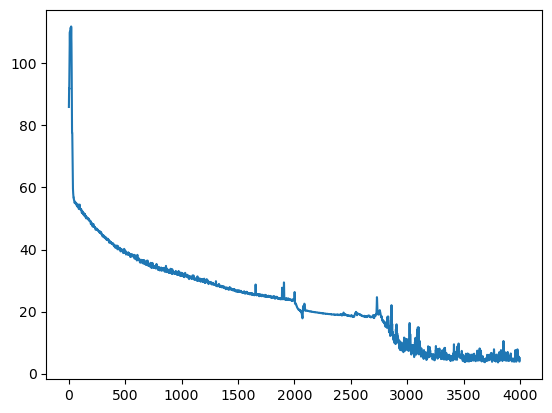

In [15]:
 from scipy.ndimage import gaussian_filter
 plt.plot(gaussian_filter(np.array(loss_history), 1))

The time course of the unit of interest now looks like our target cosine time course.

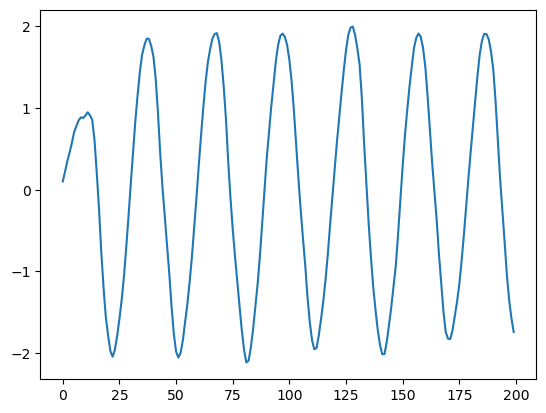

In [16]:
plt.plot(history[0:, 2, 1, 1, 1].detach().numpy())

If we look at units in other nodes / channels they have various oscillatory patterns with similar frequency. 

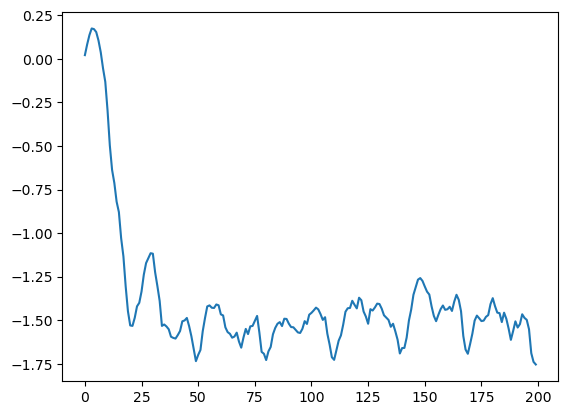

In [17]:
plt.plot(history[0:, 0, 2, 3, 2].detach().numpy())

Now show the plasticity values for each node to node edge. 

In [19]:
plast = rnet.edge.plasticity.detach().numpy()
print(plast)
# plt.imshow(plast, cmap="hot")

[[[[0.13777798 0.2865645  0.16692689]
   [0.18800843 0.22650251 0.11371067]
   [0.01947437 0.26304486 0.20647268]]

  [[0.24069914 0.1674625  0.15720116]
   [0.2587725  0.17779836 0.32688302]
   [0.2329242  0.16105051 0.27710035]]

  [[0.44264093 0.26156566 0.03448772]
   [0.26368362 0.30068743 0.04063815]
   [0.23301305 0.20465274 0.11112161]]]


 [[[0.27347004 0.25076896 0.12309097]
   [0.2484932  0.23234335 0.2560411 ]
   [0.304062   0.30313042 0.2988308 ]]

  [[0.25339362 0.18872577 0.16675146]
   [0.25662598 0.18815058 0.18048725]
   [0.22674929 0.16993266 0.2485182 ]]

  [[0.17849492 0.2880945  0.11938403]
   [0.16830543 0.2200688  0.19683598]
   [0.32128143 0.22149098 0.16817948]]]


 [[[0.15648377 0.25291115 0.3247086 ]
   [0.07184187 0.08496182 0.31497785]
   [0.17742068 0.19156392 0.2849567 ]]

  [[0.25021985 0.21935122 0.31038216]
   [0.31860006 0.03565355 0.03355276]
   [0.2661654  0.04784509 0.39122355]]

  [[0.18200779 0.16316591 0.099808  ]
   [0.16232662 0.43107173 0.24

In [11]:
import pickle
with open("../models/cos_entrained.pkl", "wb") as f:
    pickle.dump(rnet, f)

In [ ]:
print(rnet.edge.chan_map.detach().numpy())

In [ ]:
print(torch.linalg.inv(rnet.edge.chan_map.detach()).numpy())